In [5]:
# General imports
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants
from astropy.io import fits
from astropy.table import Table, join
import os
os.chdir("/Users/keith/astr/research_astr/roman_grism_sim/ultra_smooth_lambda_dependent/fits")

# Pretty plots
import matplotlib
matplotlib.rcParams["figure.figsize"] = (11,6)
matplotlib.rcParams["image.interpolation"] = "nearest"
matplotlib.rcParams["image.origin"] = "lower"

# Grizli
from grizli.model import GrismFLT

# pysynphot
import pysynphot as S

# WebbPSF
import webbpsf
import webbpsf.roman

In [6]:
# Read SED template; using G0V star template
df = Table.read("/Users/keith/astr/research_astr/FOV0/FOV0_SEDs/wfirst_wfi_f158_001_syn.fits", format='fits')
bp = S.ArrayBandpass(df["WAVELENGTH"], df["THROUGHPUT"])

spec = Table.read("/Users/keith/astr/research_astr/FOV0/FOV0_SEDs/ukg0v.dat", format="ascii")
src = S.ArraySpectrum(wave=spec["col1"], flux=spec["col2"], waveunits="angstroms", fluxunits="flam")
src = src.renorm(6, "abmag", bp)
src.convert("flam")

# PSF
wfi = webbpsf.roman.WFI()
# webbpsf.setup_logging("Error")

eff_psf = wfi.calc_psf(monochromatic=(20000 * (10**-10)), fov_pixels=182, oversample=1, source=src)[0].data
half_psf_thumb = int(eff_psf.shape[0] / 2) # Used for indexing; center_pixel plus/minus half_psf_thumb(nail)

psf_direct = np.zeros((4288, 4288))
psf_direct[(2144-half_psf_thumb): (2144+half_psf_thumb), (2144-half_psf_thumb):(2144+half_psf_thumb)] = eff_psf

In [7]:
eff_psf.shape

(182, 182)

In [8]:
# initialize grizli
pad = 100
roman = GrismFLT(direct_file="empty_direct.fits", seg_file="empty_seg.fits", pad=pad)

# add psf direct image and seg map
roman.direct.data["SCI"] = psf_direct.astype("float32")
roman.seg = np.where(roman.direct.data["SCI"], 1, 0).astype("float32")



Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None) [Out of range]
empty_direct.fits / Pad ref HDU with 264 pixels
empty_direct.fits / blot segmentation empty_seg.fits[0]
The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...


In [9]:
# set truth
spec = spec[1770:3771] # truncate spectrum to 10000-20000 angstroms
spec = Table([src.wave[1770:3771], src.flux[1770:3771]], names=["col1", "col2"])

truth = roman.compute_model_orders(id=1, mag=1, compute_size=False, size=77, is_cgs=True, 
                                   store=False, in_place=False, spectrum_1d=[spec["col1"], spec["col2"]])[1]
                                
truth_extraction = np.array([truth[:, ii].sum() for ii in range(truth.shape[1])])

In [10]:
def chunk(start_wave, end_wave):
    start_index = int((start_wave - 10000) / 5)
    end_index = int((end_wave - 10000) / 5) + 1

    chunk_spec = np.asarray(spec[start_index:end_index])

    return chunk_spec

def dispersion_model(pad, nbins, return_input=False, return_extraction=False, return_all=False):

    pad = int(pad) # overlap extent; data points
    nbins = int(nbins) # number of bins

    window_x = np.linspace(0, np.pi, pad)
    front_y = (1-np.cos(window_x)) / 2
    back_y = 1 - front_y

    bins = np.linspace(10000, 20000, nbins + 1)

    piecemeal_sim = np.zeros((4288,4288))

    input_catcher = []
    
    for ii, start_wave in enumerate(bins[:-1]):
        end_wave = bins[ii+1]

        start_wave -= (pad * 5) * 0.5 # times 5 from indicies to wavelength
        end_wave += ((pad - 1) * 5) * 0.5

        if start_wave < 10000:
            start_wave = 10000
        
        if end_wave > 20000:
            end_wave = 20000

        chunk_spec = chunk(start_wave, end_wave) # extract relevant part of spectrum
        wave = chunk_spec["col1"]
        flux = chunk_spec["col2"]

        # apodize
        if start_wave != 10000:
            flux[:pad] *= front_y

        if end_wave != 20000:
            flux[-pad:] *= back_y

        # print("wave range:", wave[0], wave[-1])
        # print("flux range:", flux[0], flux[-1])

        single_dispersion = roman.compute_model_orders(id=1, mag=1, compute_size=False, size=77, is_cgs=True, store=False,
                                                       in_place=False, spectrum_1d=[wave, flux])[1]

        piecemeal_sim += single_dispersion

        apodized_spec = Table([wave, flux], names=("wave","flux"))

        input_catcher.append(apodized_spec)

        del chunk_spec
        del flux
        del wave

    piecemeal_extraction = np.array([piecemeal_sim[:, ii].sum() for ii in range(piecemeal_sim.shape[1])])

    if return_input:
        return input_catcher

    if return_extraction:
        return piecemeal_extraction

    if return_all:
        return input_catcher, piecemeal_extraction, piecemeal_sim

    return piecemeal_sim

def combine_overlaps(table_1, table_2):

    full_input = join(table_1, table_2, keys='wave', join_type="outer")

    full_input["flux_1"].fill_value = 0
    full_input["flux_2"].fill_value = 0
    full_input = full_input.filled()

    sum = full_input["flux_1"] + full_input["flux_2"]

    sum_table = Table([full_input["wave"], sum], names=["wave", "flux"])

    return sum_table

In [11]:
pad = 20
nbins = 50

Text(0.5, 1.0, 'Plotting SED Spectrum against Binned Spectrum')

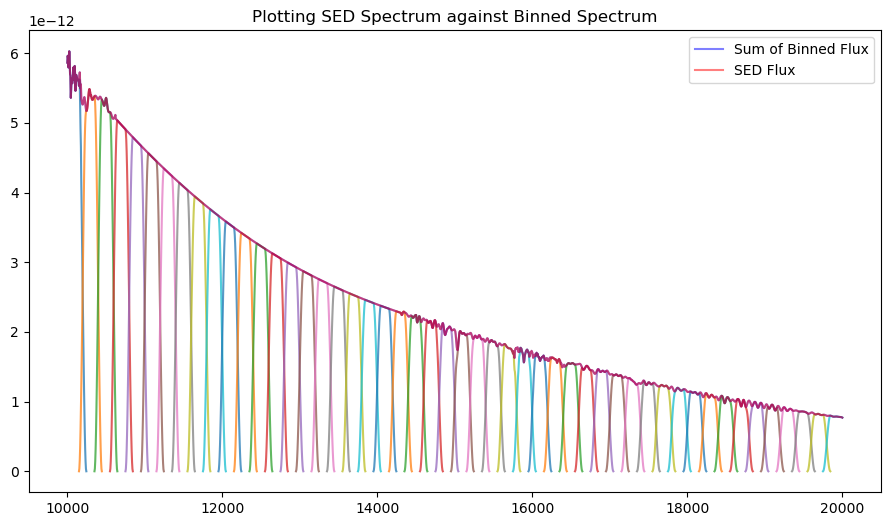

In [12]:
foo = dispersion_model(pad=pad, nbins=nbins, return_input=True)

for table in foo:
    plt.plot(table["wave"], table["flux"], alpha=0.75)

for ii in range(len(foo)):
    if ii == 0:
        full_input = foo[0]
    else:
        full_input = combine_overlaps(full_input, foo[ii])

plt.plot(full_input["wave"], full_input["flux"], color='b', alpha=0.5, label="Sum of Binned Flux")
plt.plot(spec["col1"], spec["col2"], color = 'r', alpha=0.5, label="SED Flux")

plt.legend()
plt.title("Plotting SED Spectrum against Binned Spectrum")
# plt.xlim(14500, 15500)

Text(0.5, 1.0, 'SED Flux Minus Sum of Binned Flux')

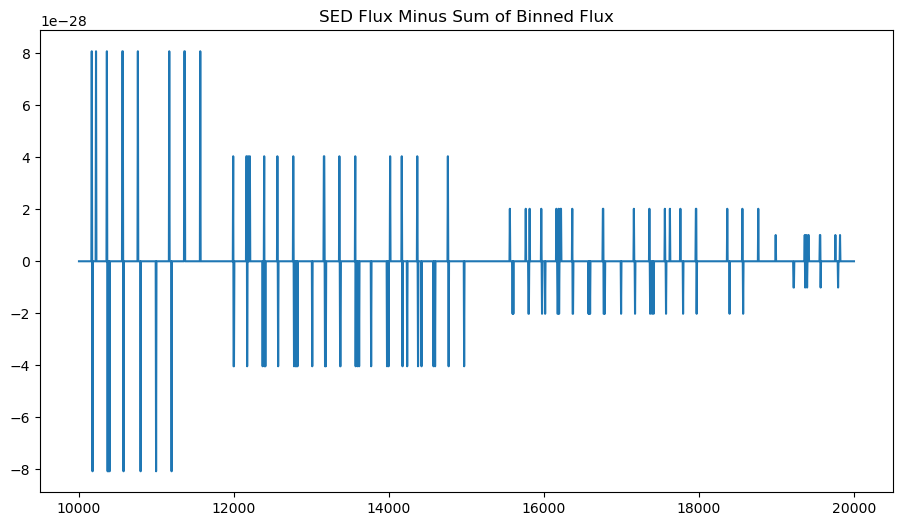

In [13]:
plt.plot(full_input["wave"], spec["col2"] - full_input["flux"])
plt.title("SED Flux Minus Sum of Binned Flux")

Text(0.5, 1.0, 'Residuals')

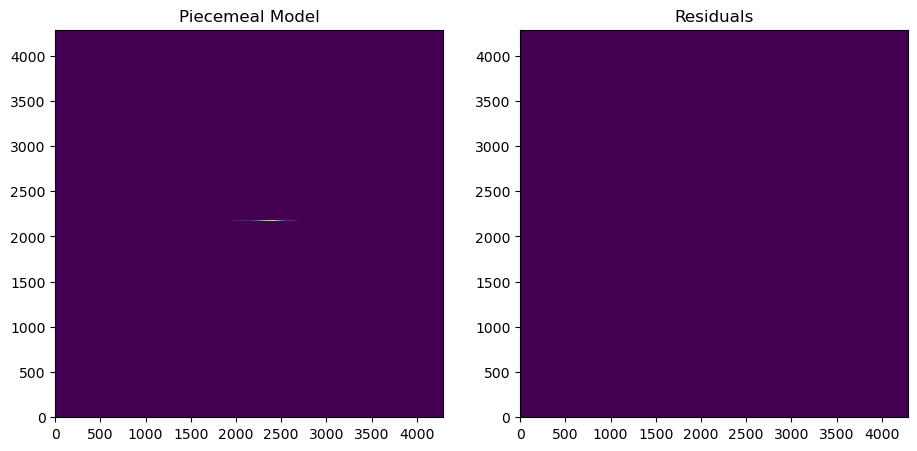

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2)

foo = dispersion_model(pad=pad, nbins=nbins)
bar = dispersion_model(pad=pad, nbins=nbins, return_extraction=True)

ax1.imshow(foo)
ax1.set_title("Piecemeal Model")

ax2.imshow(truth - foo)
ax2.set_title("Residuals")

Text(0.5, 1.0, 'Truth Minus 2-bin Piecemeal')

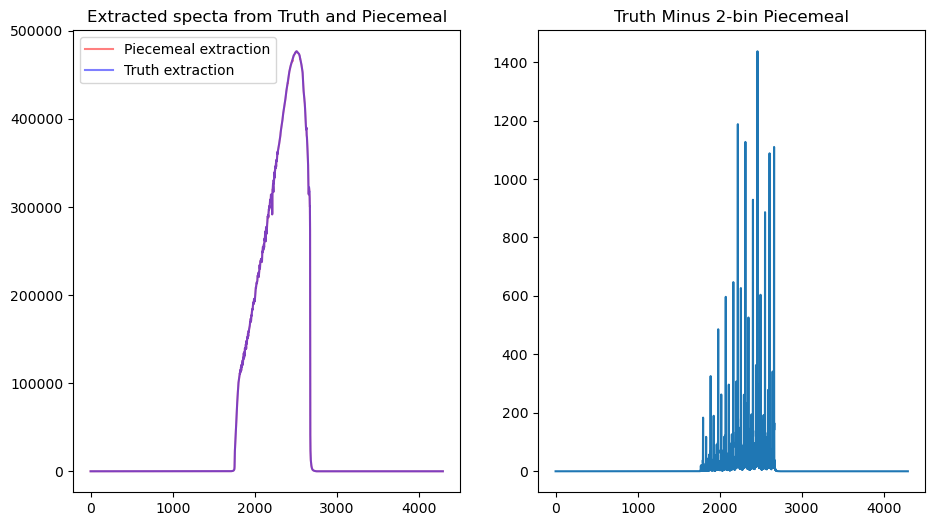

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(bar, c='r', alpha=0.5, label="Piecemeal extraction");
ax1.plot(truth_extraction, c='b', alpha=0.5, label="Truth extraction");
ax1.set_title("Extracted specta from Truth and Piecemeal")
ax1.legend()

ax2.plot(truth_extraction - bar);
ax2.set_title("Truth Minus 2-bin Piecemeal")